# パターン発見
ここで言うパターン発見とは「データから規則性を見出し、データの傾向や類似性を見つける」ことであり、機械学習では「教師なし学習」と呼ばれ以下の2つに分類できる。

- クラスタリング … 複数データをいくつかの類似グループに分ける手法
- 次元圧縮(次元削減) … 出来るだけ意味を保ったままデータ量を削減する手法

パターン発見と一緒にここで紹介する「類似」と言う概念は、様々なデータについてその類似性を計算する手法である。
多くの場合、どの程度類似しているかと言うのは距離と言う概念で考えることができるので、そのことについて確認する。

## クラスタリング
多数のデータをいくつかの類似したグループに分ける手法であり、実務ではユーザーのセグメンテーションやターゲティングなどに用いられる。

- セグメンテーション ... 対象をいくつかのグループに分けてどのような分類して特徴付けること
- ターゲティング ... 対象の中で特に重要な部分にフォーカスすること

クラスタリングについても予測手法と同様様々な方法があるが、ここでは「Movie Lens」と言うデータセットを用い、代表的なk-meansと言う手法を通してクラスタリングの流れを確認する。k-meansの中身を知りたい場合は以下の書籍がおすすめ。

- 概要を知りたい場合: 『[Python機械学習プログラミング 達人データサイエンティストによる理論と実践](https://www.amazon.co.jp/dp/B01HGIPIAK)』の11章
- 詳細を理解したい場合: 『[続・わかりやすい　パターン認識 －教師なし学習入門－](https://www.amazon.co.jp/dp/B081G8Y5SD/)』の10章

## Movie Lens
> F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages. DOI=http://dx.doi.org/10.1145/2827872

- 映画のレビューサイトでの映画の情報とユーザーによる評価のデータ
- 本来は推薦システムの構築評価を目的としてデータセットだが、データ分析の題材としても面白いので用いる

### 映画情報
Movie Lensデータは映画情報のデータ、ユーザーのデータ、ユーザーの評価データなどから構成されるが、今回用いる映画情報のデータは以下のような列で構成される。

- movie id ... 映画のID
- movie title ... 映画のタイトル
- release date ... リリース日
- video release date ... ビデオのリリース日
- IMDb URL ... データセットの元となるURL（アクセスすると情報が見れる）
- 映画のジャンル情報（19列分ある、条件が一致する場合1でそうでない場合は0となる）

In [1]:
# 必要なライブラリの読み込み
import pandas as pd
import numpy as np

# 可視化
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# データセットの読み込み
url = 'http://files.grouplens.org/datasets/movielens/ml-100k/u.item'
movie_df = pd.read_csv(url, sep='|', header=None, encoding='latin-1')

In [3]:
# 列情報の追加
# ホームページから取得 http://files.grouplens.org/datasets/movielens/ml-100k-README.txt
col_info = "id | movie title | release date | video release date | IMDb URL | unknown | Action | Adventure | Animation | Children's | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western"
col_names = col_info.split(" | ")

# 列名を追加
movie_df.columns = col_names

In [4]:
print("データフレームの形: ", movie_df.shape)
movie_df.head()

データフレームの形:  (1682, 24)


,id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## クラスタリングの流れ
クラスタリングの流れも予測の時と同様に以下のようなステップを踏むことが多い。

1. データの準備
2. クラスタリングの実行
3. データの解釈を進める

ここでは映画をそのジャンル情報に基づいて分類してみる。

実際の業務では「現在のジャンル分類方法に変わる、もう少し大まかななジャンルがあればそれを元にユーザーにリーチしたい」といった課題例がある。

### 1. データの準備

In [5]:
# 今回はすでにMovie Lensデータを読み込んでいるので、利用する特徴量（列）を絞り込むところからスタートする。
# ジャンル情報列のみ抽出して入力データを作成する
X = movie_df[col_names[5:]]

### 2. クラスタリングの実行

In [6]:
# KMeansクラスの読み込み
from sklearn.cluster import KMeans

# 分類するグループ数（クラスタ数）を指定して実行
#   注意）
#   最適なクラスタ数は探索的にデータを分析したり、「エルボー法」などと呼ばれる方法を使って推定することが多い
#   今回は練習のために「3」で決め打ち
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)

### 3. 解釈のための準備

In [7]:
# 予測データを元のデータと組み合わせる
movie_df['cluster_label'] = kmeans.labels_

In [8]:
# それぞれのクラスタのデータサイズを確認する
label_size = movie_df['cluster_label'].value_counts().sort_index()
label_size

0    208
1    721
2    403
3    350
Name: cluster_label, dtype: int64

In [9]:
# それぞれのクラスタのデータ数割合も確認する
label_size / label_size.sum()

0    0.123662
1    0.428656
2    0.239596
3    0.208086
Name: cluster_label, dtype: float64

In [10]:
# 結果の解釈
#   それぞれのクラスタがどのようなジャンルになっているかを確認することで解釈をする
#   ここではそれぞれのクラスタのジャンルの個数の割合がどうなっているかを確認する
cluster_genre_df = movie_df[col_names[5:] + ['cluster_label']].groupby('cluster_label').sum().T
cluster_genre_ratio_df = (cluster_genre_df / cluster_genre_df.sum())
cluster_genre_ratio_df.head()

cluster_label,0,1,2,3
unknown,0.000000,0.000000,0.000000,0.003650
Action,0.261538,0.035745,0.027692,0.100365
Adventure,0.226923,0.008511,0.007692,0.003650
Animation,0.059615,0.000000,0.012308,0.005474
Children's,0.126923,0.016170,0.056923,0.000000


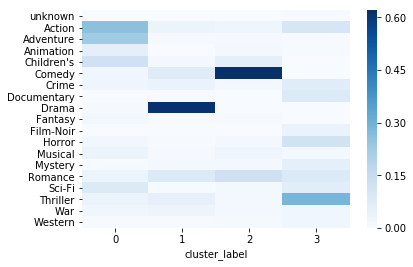

In [11]:
#   ヒートマップと呼ばれる可視化手法により可視化
sns.heatmap(cluster_genre_ratio_df, cmap='Blues')

### データの解釈
このフェーズではやや詩人のような心が必要となる。データの傾向を把握できるように、それぞれのクラスタについて分かりやすい解釈を与えられるように意識する。

- **クラスタ0** ... Action、Adventure、Children's、Sci-Fiといったジャンルが特徴的な「アクションア/ドベンチャー/SF/子供向け」のジャンルと考えられる（12.3%）
- **クラスタ1** ... Dramaが特に特徴的で「ドラマ系」のクラスタと考えられる（42.9%）
- **クラスタ2** ... ComedyやRomanceが特徴的で「ロマンス/コメディー」のクラスタと考えられる （24.0%）
- **クラスタ3** ... Thrillerを中心として多くのジャンルが含まれているのが特徴的であり「スリラー/その他」のクラスタ（20.8%）

このように、1682本の映画をジャンル情報を元に、4つの特徴あるグループに分類することができた。

人手で2000本近い映画を4つのグループに分けるのは非常に骨の折れる作業であることを考えると、クラスタリングの威力を実感できるだろう。

## 次元圧縮(次元削減)
大量の特徴量を出来るだけ意味を失わないように、少数の特徴量に変換する手法であり、その目的は主に以下の2つがある。

- 予測のための前処理
- データ可視化のための補助

ここでは、後者の「データ可視化のための補助」と言う文脈の次元圧縮を紹介する。
前の項目と同様に次元圧縮は様々な手法があるが、ここではMovie Lensデータを用い、次元圧縮の代表的な手法である主成分分析（Principle Component Analysis: PCA）による流れを確認していく。

### 次元圧縮の流れ
次元圧縮の流れもクラスタリングの時と同様なステップを踏むことが多い。

1. データの準備
2. 次元圧縮の実行
3. データを眺める

ここでは映画データのそのジャンル特徴量（19コ）を次元圧縮によって2つの新たな特徴量に変換することに挑戦する。

実際の業務では「それぞれの映画の関係を知りたいが、19個も特徴量があると可視化して表しにくいので、なんとかして二次元平面でプロットして全体像を把握したい」といった課題例があげられる。

### 主成分分析
主成分分析の概要を押さえる。

- 主成分分析は行列データ（今まで扱っているような表データ）から行列データへの変換処理である
- 変換された行列データの列は0番目から順に重要度を持っている
  - 例えば10列の表データをインプットとした場合、変換後の表データは以下のような情報をもつ
      - 1列目→重要度0.8
      - 2列目→重要度0.1
      - 3列目→重要度0.5
      - ... といった形になる
- 何列目までのデータを使って、元の表データの近似とするかは都度判断が必要

参考文献は以下がおすすめ。

- 概要を知りたい場合: 『[Python機械学習プログラミング 達人データサイエンティストによる理論と実践](https://www.amazon.co.jp/dp/B01HGIPIAK)』の5章
- 詳細を知りたい場合: [主成分分析(PCA)の数学的な理論とPythonによる実装](https://noppoman.github.io/mathematical-theory-of-pca-ja/)

In [12]:
# データの準備
#   ジャンル情報列のみ抽出して入力データを作成する
X = movie_df[col_names[5:]]

In [13]:
# 次元圧縮のクラスを読み込み
from sklearn.decomposition import PCA

# 次元圧縮を実行
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [14]:
# それぞれの列の分散説明率（上記の説明での重要度に相当）を確認
#   元データの何割ほど説明ができているかを表す指標
print("分散説明率", pca.explained_variance_ratio_)
print("累積分散説明率", pca.explained_variance_ratio_.sum())

分散説明率 [0.2315764  0.17370217]
累積分散説明率 0.405278573091426


### データを眺める
- ここまでの処理により、2つの軸を用いることによって40%ほどの情報を集約できることがわかった
- 反対に2つの軸で表現することによって60%ほどの情報が失われている
- これらの軸は計算により自動的に求められたものであるので、より分かりやすくする場合は人手による解釈が必要となる
  - 元となる特徴量(列)の組み合わせにより表せることが多いので、今回の場合「SFやアドベンチャーの要素を表す軸」といった解釈ができる場合がある
- 新たに得られた特徴量を元に2次元の散布図などを用いてデータの傾向を把握することができる

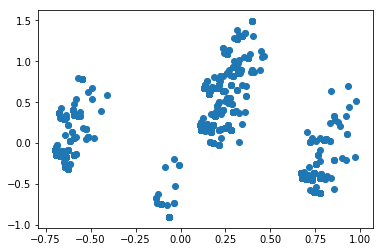

In [15]:
# データの可視化
plt.scatter(x=X_pca[:,0], y=X_pca[:,1])

In [16]:
# 新たに主成分分析によって求められた2つの特徴量をもつ表データを作成
import copy
pca_movie_df = copy.deepcopy(movie_df[['movie title']])
pca_movie_df['pca1'] = X_pca[:,0]
pca_movie_df['pca2'] = X_pca[:,1]

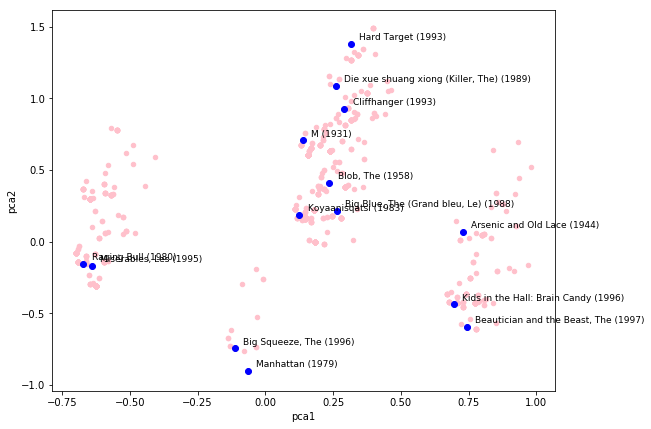

In [17]:
# いくつか映画のタイトルをプロットしてみる
pca_movie_df.plot(kind="scatter", x='pca1', y='pca2', figsize=(9, 7), color='pink')

# いくつかピックアップしてタイトルをプロット
sampled_movie_df = pca_movie_df.sample(14, random_state=0)
plt.scatter(x=sampled_movie_df['pca1'], y=sampled_movie_df['pca2'], color='blue')
for i, row in sampled_movie_df.iterrows():
    x, y, title = row.pca1, row.pca2, row['movie title']
    plt.text(x+.03, y+.03, title, fontsize=9)

## 類似度
類似度は機械学習に限らずデータサイエンスでよく用いられる重要な概念のの1つで、何らかの尺度に基づいて2つ以上のデータ間を類似性を測ることができます。

例えば、以下のような課題を解決するのに用いることができる。

- とある商品と似たような商品を探したい
- SNSで似ているユーザーを推薦したい
- などなど

ここでは、今まで見てきた映画データセットを用いて、類似度により類似した映画を発見する方法を見ていく。

### 類似度の測り方
類似度の基本的なコンセプトは、2つの要素（ここではベクトルとする）に関してその何らかの方法を使ってそれらの似ている度合いを計算することである。
ここでベクトルと言うのは、表データにおける各行のようなもので、以下のように要素を横に並べたものである。

$$\vec{x} = (x_1, x_2, ..., x_n)$$

 上記のベクトル$v$をn次元ベクトルと言う。（ただの用語）
 
 類似度はこうしたベクトルについて、2つのベクトルを入力として何らかの類似度を出力する計算結果である。例えば$\vec{x}$と$\vec{y}$が会った時にその計算方法を$f(\vec{x}, \vec{y})$とすると、以下のように計算できる。
 
$$類似度 = f(\vec{x}, \vec{y})$$

類似度の計算方法についても様々な方法があるが、今回はその中でも比較的よく使われるコサイン類似度と言う指標を紹介する

### コサイン類似度
$\vec{x}=(x1, x2, ..., x_n)$と$\vec{y}=(y1, y2, ..., y_n)$の2つのベクトルで、コサイン類似度を求める場合は以下のように求められる。

$$
コサイン類似度=\frac{x_1y_1 + x_2y_2 + x_ny_n}{\sqrt{x_1^2 + x_2^2 + ... + x_n^2}\sqrt{y_1^2 + y_2^2 + ... + y_n^2}}
$$

ベクトルの各要素は表データの各列（特徴量）であることから、分子の形から各特徴量が同じ方向を向いていればいるほど大きくなることが分かる。
分母では、要素としてどんな値が出てきても、最終的な指標の値を-1〜+1の範囲に揃える働きががあることがわかれば良い。

In [18]:
# コサイン類似度
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [19]:
# トイストーリーとの類似度計算
movie_name = 'Toy Story (1995)'

# その他の映画
#movie_name = 'E.T. the Extra-Terrestrial (1982)'
#movie_name = 'Alien (1979)'
movie_vector = pca_movie_df[pca_movie_df['movie title'] == movie_name][['pca1', 'pca2']].values[0,:]
movie_vector

array([ 0.80601124, -0.41111641])

In [20]:
# 類似度を計算して追加
similalities = []
for k, row in pca_movie_df[['pca1', 'pca2']].iterrows():
    similarity = cos_sim(movie_vector, [row['pca1'], row['pca2']])
    similalities.append(similarity)

pca_movie_df['cosine_similarity'] = np.array(similalities)

In [21]:
# 類似度の高い順に並び替え
pca_movie_df.sort_values(by='cosine_similarity', ascending=False).head()

,movie title,pca1,pca2,cosine_similarity
421,Aladdin and the King of Thieves (1996),0.806011,-0.411116,1.000000
0,Toy Story (1995),0.806011,-0.411116,1.000000
94,Aladdin (1992),0.838949,-0.426713,0.999999
71,"Mask, The (1994)",0.684304,-0.354994,0.999976
636,"Howling, The (1981)",0.740526,-0.366857,0.999932
